In [6]:
import numpy as np

image_mean = np.array([
    0.485,
    0.456,
    0.406
])
image_std = np.array([
    0.229,
    0.224,
    0.225
])


def undo_transforms(video):
    return video * image_std[None, None, :] + image_mean[None, None, :]

anchor_sizes: ((11.313708498984761, 16.0, 19.027313840043536, 22.627416997969522, 26.908685288118864), (22.627416997969522, 32.0, 38.05462768008707, 45.254833995939045, 53.81737057623773), (45.254833995939045, 64.0, 76.10925536017415, 90.50966799187809, 107.63474115247546), (90.50966799187809, 128.0, 152.2185107203483, 181.01933598375618, 215.2694823049509))
aspect_ratios: ((0.2, 0.33, 0.5, 1.0, 2), (0.2, 0.33, 0.5, 1.0, 2), (0.2, 0.33, 0.5, 1.0, 2), (0.2, 0.33, 0.5, 1.0, 2))
BitImageProcessorFast {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "data_format": "channels_first",
  "default_to_square": false,
  "device": null,
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "BitImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "input_data_format": null,
  "resample": 3,
  "rescale_factor": 0.0039215

  0%|          | 0/30 [00:00<?, ?it/s]

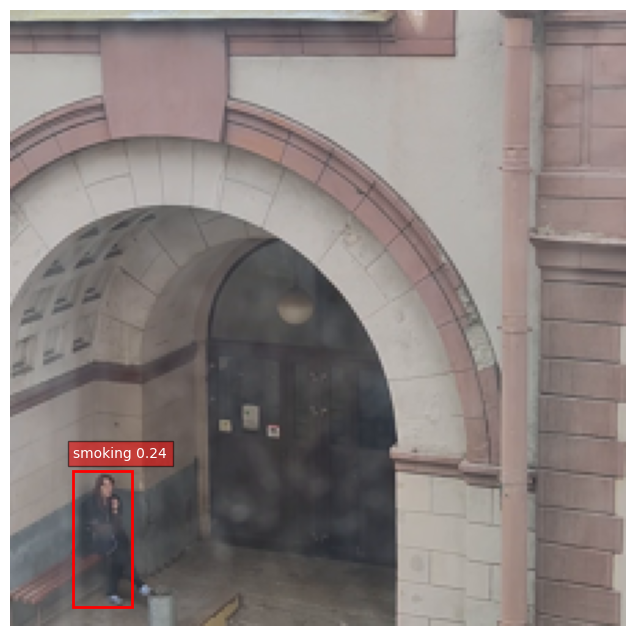

  3%|▎         | 1/30 [00:09<04:41,  9.72s/it]


In [31]:
import os
from matplotlib import pyplot as plt
from evaluate import evaluator
from tqdm import tqdm
from transformers import AutoImageProcessor
from src.data.dataset_collected import ActionDetectionDataset
from torch.utils.data import DataLoader
import torch
from src.models.model_hiera_base import HieraActionDetector
from src.data.dataset_collected import collate_fn

num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HieraActionDetector(num_classes, use_focal_loss=True).to(device)
val_csv_file_path = "../hiera_test/dataset_final/part_2/project-2_annotations.csv"

val_epoch_size_ratio = 10

image_processor = AutoImageProcessor.from_pretrained("facebook/hiera-base-224-hf", use_fast=True)

print(image_processor)

frame_sample_rate = 2
clip_len = 16

cls = [
    "smoking",
    "talking phone"
]

class_to_idx = {cl: i + 1 for i, cl in enumerate(cls)}
class_to_idx['background'] = 0
idx_to_class = {v: k for k, v in class_to_idx.items()}

image_dataset = ActionDetectionDataset("../hiera_test", val_csv_file_path,
                                       oversample=False,
                                       epoch_size_ratio=val_epoch_size_ratio,
                                       processor=image_processor,
                                       frame_sample_rate=frame_sample_rate,
                                       clip_len=clip_len,
                                       length_file=f"./{val_csv_file_path.split("/")[-1]}.json",
                                       class_to_idx=class_to_idx)

batch_size = 4

dataloader_test = DataLoader(image_dataset,
                             batch_size=batch_size,
                             pin_memory=True,
                             collate_fn=collate_fn)

load_checkpoint = "../runs/hiera_mydataset_20ep_6bs_16cliplen-2fsr-2__2025__20250623_144452/hiera_mydataset_20ep_6bs_16cliplen-2fsr-2_head_epoch20.pth"

checkpoint = torch.load(load_checkpoint, weights_only=True, map_location=device)
model.load_state_dict(checkpoint['model'])
start_epoch = checkpoint['epoch']

model.eval()
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader_test)):
        if i >= 1:
            break
        inputs = batch['video'].to(device)
        boxes = [b.to(device) for b in batch['bbox']]
        labels = [t.to(device) for t in batch['target']]

        detection_results, losses = model.forward(inputs, boxes, labels)

        video_tensor = batch['video'][0]
        middle_frame_idx = video_tensor.shape[1] // 2
        frame = undo_transforms(video_tensor[:, middle_frame_idx].permute(1, 2, 0).cpu().numpy())
        boxes = detection_results[0]['boxes'].cpu().numpy()
        scores = detection_results[0]['scores'].cpu().numpy()
        labels = detection_results[0]['labels'].cpu().numpy()
        plt.figure(figsize=(10, 8))
        if len(scores) != 0:
            box = boxes[np.argmax(scores)]
            label = labels[np.argmax(scores)]
            score = scores[np.argmax(scores)]
        plt.imshow(frame)

        x1, y1, x2, y2 = box
        class_name = idx_to_class[int(label)]
        plt.gca().add_patch(
            plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
        )
        plt.text(x1, y1 - 5, f"{class_name} {score:.2f}",
                 bbox=dict(facecolor='red', alpha=0.5), fontsize=10, color='white')

        plt.axis('off')
        plt.show()
        plt.close()
